In [1]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
archivo_csv = "GRD_PUBLICO_2023.csv"
df = pd.read_csv(archivo_csv, sep='|', on_bad_lines='skip', engine='python', encoding='utf-16')
print(f"Datos cargados exitosamente: {df.shape[0]:,} registros")




display(df.head(5))

Datos cargados exitosamente: 1,039,587 registros


,COD_HOSPITAL,CIP_ENCRIPTADO,SEXO,FECHA_NACIMIENTO,ETNIA,PROVINCIA,COMUNA,NACIONALIDAD,PREVISION,SERVICIO_SALUD,...,FECHAPROCEDIMIENTO1,FECHAINTERV1,ESPECIALIDADINTERVENCION,MEDICOALTA_ENCRIPTADO,USOSPABELLON,IR_29301_COD_GRD,IR_29301_PESO,IR_29301_SEVERIDAD,IR_29301_MORTALIDAD,HOSPPROCEDENCIA
0,122100,72196813,HOMBRE,1980-04-13,OTRO,VALDIVIA,PANGUIPULLI,CHILE,FONASA INSTITUCIONAL - (MAI) A,VALDIVIA,...,NaN,NaN,NaN,87553213,NaN,064161,"0,7094",1,1,NaN
1,114101,DESCONOCIDO,HOMBRE,2001-11-04,OTRO,CORDILLERA,PUENTE ALTO,VENEZUELA (REPÚBLICA BOLIVARIANA DE),PARTICULAR,METROPOLITANO SURORIENTE,...,NaN,NaN,NaN,86895434,1.0,041301,"1,0869",1,1,NaN
2,114101,97627974,HOMBRE,2020-07-30,OTRO,CORDILLERA,PUENTE ALTO,CHILE,FONASA INSTITUCIONAL - (MAI) A,METROPOLITANO SURORIENTE,...,NaN,NaN,NaN,73227424,NaN,044161,"0,4084",1,1,NaN
3,106103,67770674,MUJER,1978-11-14,OTRO,SAN ANTONIO,SAN ANTONIO,CHILE,FONASA INSTITUCIONAL - (MAI) C,VALPARAISO SAN ANTONIO,...,NaN,25-05-2023,OBSTETRICIA Y GINECOLOGÍA,71695588,1.0,131301,"0,6406",1,1,NaN
4,106103,100390800,MUJER,2023-12-20,OTRO,SAN ANTONIO,SAN ANTONIO,CHILE,FONASA INSTITUCIONAL - (MAI) B,VALPARAISO SAN ANTONIO,...,NaN,NaN,NaN,71644222,NaN,074131,"0,5346",1,1,NaN


### **Pregunta Investigación**

¿Existe una diferencia entre el tiempo de estancia entre hospitales de la región metropolitana y los que están fuera de esta, para pacientes con características similares?

### **Definición Experimental**

**Población Objetivo:** Pacientes mayores de 18 años que se encuentran en el registro GRD de todo el país.

**Métricas Primarias:** Tiempo estancia, Tipo Región

**Métricas Secundarias/Confusoras:** 
- Edad
- Sexo 
- Tipo de Ingreso
- Previsión

**Criterios de Inclusión:**
- Pacientes mayores de 18 años
- Que tengan registro de su edad, sexo, tipo de ingreso.

**Criterios de exclusión:**
- Pacientes de los que no se conozca su previsión
- Pacientes que son atendidos en Servicios de Salud Públicos de Chile.

### **Diseño Estadístico**

**Tamaño Muestral Necesario**



In [3]:
from statsmodels.stats.power import TTestIndPower

# Definir parámetros
SD = 0.3  # tamaño del efecto (0.5 SD)
alpha = 0.05  # nivel de significancia
power = 0.8  # potencia deseada

# Calcular tamaño muestral por grupo
analysis = TTestIndPower()
sample_size_per_group = analysis.solve_power(effect_size=SD, alpha=alpha, power=power, alternative='two-sided')
total_sample_size = sample_size_per_group * 2

print(f"Tamaño muestral necesario por grupo: {round(sample_size_per_group)}")
print(f"Tamaño muestral total: {round(total_sample_size)}")

Tamaño muestral necesario por grupo: 175
Tamaño muestral total: 351


In [4]:


df["FECHAALTA"] = pd.to_datetime(df["FECHAALTA"], dayfirst=True)
df["FECHA_INGRESO"] = pd.to_datetime(df["FECHA_INGRESO"], dayfirst=True)

df["TIEMPO_ESTANCIA"] = (df["FECHAALTA"]-df["FECHA_INGRESO"])
df["TIEMPO_ESTANCIA"] = df["TIEMPO_ESTANCIA"].dt.days

df[["FECHAALTA","FECHA_INGRESO","TIEMPO_ESTANCIA"]].sample()


df['FECHA_NACIMIENTO'] = df[df['FECHA_NACIMIENTO'] != "DESCONOCIDO"]["FECHA_NACIMIENTO"]
df['FECHA_INGRESO'] = df[df['FECHA_INGRESO'] != "DESCONOCIDO"]["FECHA_INGRESO"]
df['FECHAALTA'] = df[df['FECHAALTA'] != "DESCONOCIDO"]["FECHAALTA"]

df['FECHA_NACIMIENTO'] = pd.to_datetime(df['FECHA_NACIMIENTO'], dayfirst=True)
df['FECHA_INGRESO'] = pd.to_datetime(df['FECHA_INGRESO'], dayfirst=True)
df['FECHAALTA'] = pd.to_datetime(df['FECHAALTA'], dayfirst=True)
df['EDAD'] = ((df['FECHA_INGRESO'] - df['FECHA_NACIMIENTO']).dt.days / 365.25).round().astype('Int64')

C:\Users\Darienn\AppData\Local\Temp\ipykernel_16472\3419132282.py:14: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['FECHA_NACIMIENTO'] = pd.to_datetime(df['FECHA_NACIMIENTO'], dayfirst=True)


**Método de aleatorización**

Se categorizarán dos grupos a partir de la ubicación geografica del servicio de salud donde ocurra la atención.

In [5]:
valores = list(df["SERVICIO_SALUD"].unique())
valores

diccionario = {}
for i in valores:
    if "METROPOLITANO" in i:
        diccionario[i] = "METROPOLITANO"
    else:
        diccionario[i] = "PROVINCIA"
        
diccionario

df["TipoRegion"] = df["SERVICIO_SALUD"].map(diccionario)
df = df[df["TipoRegion"] != "DESCONOCIDO"]

In [6]:
diccionario = {}
for i in valores:
    if "METROPOLITANO" in i:
        diccionario[i] = "METROPOLITANO"

    elif "ARAUCANÍA" in i: 
        diccionario[i] = "ARAUCANÍA"

    elif "VIÑA" in i or "VALPARAISO" in i or "ACONCAGUA" in i: 
        diccionario[i] = "VALPARAISO"

    elif "VALDIVIA" in i:
        diccionario[i] = "RIOS"

    elif "RELONCAVÍ" in i or "OSORNO" in i or "CHILOÉ" in i:
        diccionario[i] = "LAGOS"

    elif "TALCAHUANO" in i or "CONCEPCIÓN" in i or "BIOBIO" in i or "ARAUCO" in i:
        diccionario[i] = "BIOBIO"

    elif "IQUIQUE" in i:
        diccionario[i] = "TARAPACA"

    else:
        diccionario[i] = i

print(diccionario)

df["Region"] = df["SERVICIO_SALUD"].map(diccionario)
df = df[df["Region"] != "DESCONOCIDO"]
data = df[df["Region"]!="AYSEN"]

{'VALDIVIA': 'RIOS', 'METROPOLITANO SURORIENTE': 'METROPOLITANO', 'VALPARAISO SAN ANTONIO': 'VALPARAISO', 'ACONCAGUA': 'VALPARAISO', 'METROPOLITANO ORIENTE': 'METROPOLITANO', 'COQUIMBO': 'COQUIMBO', 'DEL RELONCAVÍ': 'LAGOS', 'DEL MAULE': 'DEL MAULE', 'LIBERTADOR B. O HIGGINS': 'LIBERTADOR B. O HIGGINS', 'VIÑA DEL MAR QUILLOTA': 'VALPARAISO', 'ARAUCANÍA SUR': 'ARAUCANÍA', 'METROPOLITANO CENTRAL': 'METROPOLITANO', 'ARAUCANÍA NORTE': 'ARAUCANÍA', 'TALCAHUANO': 'BIOBIO', 'METROPOLITANO OCCIDENTE': 'METROPOLITANO', 'IQUIQUE': 'TARAPACA', 'OSORNO': 'LAGOS', 'ANTOFAGASTA': 'ANTOFAGASTA', 'CONCEPCIÓN': 'BIOBIO', 'ARICA': 'ARICA', 'ÑUBLE': 'ÑUBLE', 'ATACAMA': 'ATACAMA', 'AYSEN': 'AYSEN', 'METROPOLITANO SUR': 'METROPOLITANO', 'METROPOLITANO NORTE': 'METROPOLITANO', 'BIOBIO': 'BIOBIO', 'ARAUCO': 'BIOBIO', 'CHILOÉ': 'LAGOS', 'DESCONOCIDO': 'DESCONOCIDO', 'MAGALLANES': 'MAGALLANES'}


In [7]:
# Create a new column 'metropolitano' with 1 for 'METROPOLITANO' and 0 otherwise
df["metropolitano"] = (df["TipoRegion"] == "METROPOLITANO").astype(int)

# Split the dataframe into two groups based on the 'metropolitano' column
metropolitana = df[df['metropolitano'] == 1]
provincias = df[df['metropolitano'] == 0]

In [8]:
df.columns

Index(['COD_HOSPITAL', 'CIP_ENCRIPTADO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'IR_29301_COD_GRD', 'IR_29301_PESO', 'IR_29301_SEVERIDAD',
       'IR_29301_MORTALIDAD', 'HOSPPROCEDENCIA', 'TIEMPO_ESTANCIA', 'EDAD',
       'TipoRegion', 'Region', 'metropolitano'],
      dtype='object', length=134)

Límite inferior: -6.50
Límite superior: 13.50
Número de outliers: 106257
Index(['COD_HOSPITAL', 'CIP_ENCRIPTADO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'IR_29301_COD_GRD', 'IR_29301_PESO', 'IR_29301_SEVERIDAD',
       'IR_29301_MORTALIDAD', 'HOSPPROCEDENCIA', 'TIEMPO_ESTANCIA', 'EDAD',
       'TipoRegion', 'Region', 'metropolitano'],
      dtype='object', length=134)


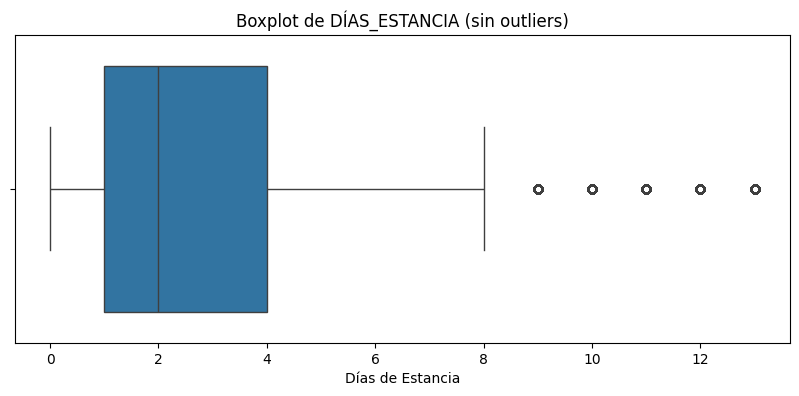

In [9]:
# Análisis de outliers en la variable TIEMPO_ESTANCIA
from matplotlib.ticker import ScalarFormatter

# Cálculo de límites usando el método IQR
q1 = df["TIEMPO_ESTANCIA"].quantile(0.25)
q3 = df["TIEMPO_ESTANCIA"].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

print(f"Límite inferior: {limite_inferior:.2f}")
print(f"Límite superior: {limite_superior:.2f}")

# Identificación de outliers
outliers = df[(df["TIEMPO_ESTANCIA"] < limite_inferior) | (df["TIEMPO_ESTANCIA"] > limite_superior)]
print(f"Número de outliers: {len(outliers)}")

# DataFrame sin outliers
df_sin_outliers = df[(df["TIEMPO_ESTANCIA"] >= limite_inferior) & (df["TIEMPO_ESTANCIA"] <= limite_superior)]
print(df_sin_outliers.columns)
# Visualización sin outliers
plt.figure(figsize=(10, 4))
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='x')  # También ayuda a forzar notación normal
sns.boxplot(x=df_sin_outliers["TIEMPO_ESTANCIA"])
plt.title("Boxplot de DÍAS_ESTANCIA (sin outliers)")
plt.xlabel("Días de Estancia")
plt.show()

C:\Users\Darienn\AppData\Local\Temp\ipykernel_16472\1502839129.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


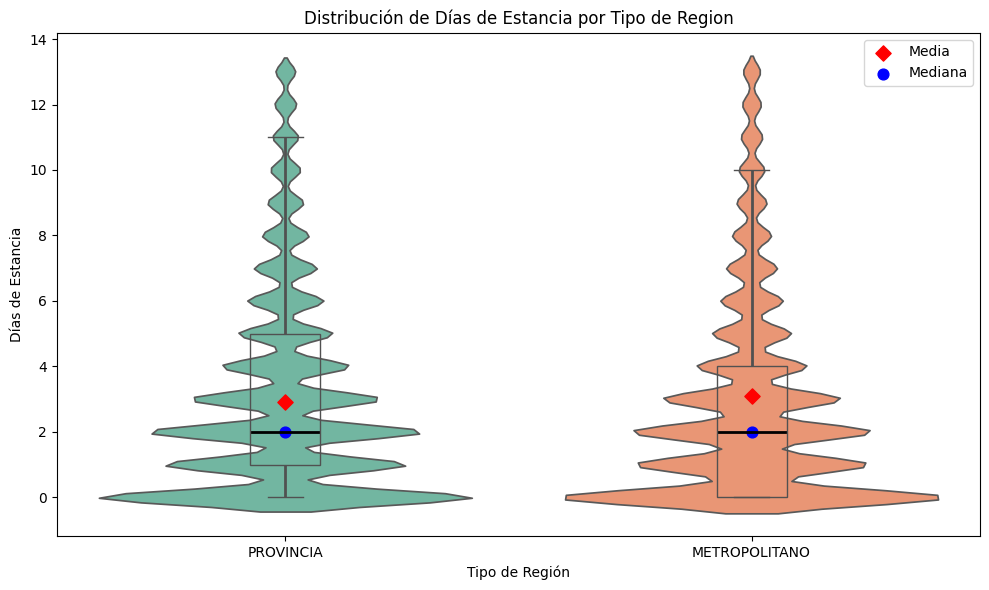

In [10]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_sin_outliers,
    x="TipoRegion",
    y="TIEMPO_ESTANCIA",
    inner=None,
    palette="Set2"
)
sns.boxplot(
    data=df_sin_outliers,
    x="TipoRegion",
    y="TIEMPO_ESTANCIA",
    width=0.15,
    showcaps=True,
    boxprops={'facecolor':'none', "zorder":10},
    showfliers=False,
    whiskerprops={'linewidth':2},
    medianprops={'color':'black', 'linewidth':2}
)

# Calcular medias y medianas por severidad
medias = df_sin_outliers.groupby("TipoRegion")["TIEMPO_ESTANCIA"].mean()
medianas = df_sin_outliers.groupby("TipoRegion")["TIEMPO_ESTANCIA"].median()

# Añadir puntos de media y mediana
for i, sev in enumerate(sorted(df_sin_outliers["TipoRegion"].unique())):
    plt.scatter(i, medias[sev], color="red", marker="D", s=60, label="Media" if i==0 else "")
    plt.scatter(i, medianas[sev], color="blue", marker="o", s=60, label="Mediana" if i==0 else "")

plt.xlabel("Tipo de Región")
plt.ylabel("Días de Estancia")
plt.title("Distribución de Días de Estancia por Tipo de Region")
plt.legend()
plt.tight_layout()
plt.show()

**Prueba Estadística Adecuada**

Prueba t para muestras indepencientes.

**Nivel de Significancia y Potencia Deseada**

Significancia de 0.05 y potencia deseada de 0.8.

In [11]:
print(df_sin_outliers.columns)
data = df_sin_outliers[["TipoRegion","Region","TIPO_INGRESO","TIEMPO_ESTANCIA","EDAD","SEXO","PREVISION"]].dropna()
data["TipoRegion"].unique()

Index(['COD_HOSPITAL', 'CIP_ENCRIPTADO', 'SEXO', 'FECHA_NACIMIENTO', 'ETNIA',
       'PROVINCIA', 'COMUNA', 'NACIONALIDAD', 'PREVISION', 'SERVICIO_SALUD',
       ...
       'IR_29301_COD_GRD', 'IR_29301_PESO', 'IR_29301_SEVERIDAD',
       'IR_29301_MORTALIDAD', 'HOSPPROCEDENCIA', 'TIEMPO_ESTANCIA', 'EDAD',
       'TipoRegion', 'Region', 'metropolitano'],
      dtype='object', length=134)


array(['PROVINCIA', 'METROPOLITANO'], dtype=object)

In [12]:
metropolitana = data[data["TipoRegion"] == "METROPOLITANO"]
provincias = data[data["TipoRegion"] == "PROVINCIA"]

provincias.sample(5)

,TipoRegion,Region,TIPO_INGRESO,TIEMPO_ESTANCIA,EDAD,SEXO,PREVISION
500314,PROVINCIA,LIBERTADOR B. O HIGGINS,URGENCIA,6,15,MUJER,FONASA INSTITUCIONAL - (MAI) A
929337,PROVINCIA,ANTOFAGASTA,OBSTETRICA,3,44,MUJER,FONASA INSTITUCIONAL - (MAI) A
55221,PROVINCIA,ARAUCANÍA,OBSTETRICA,1,26,MUJER,FONASA INSTITUCIONAL - (MAI) C
1038467,PROVINCIA,MAGALLANES,URGENCIA,1,44,MUJER,FONASA INSTITUCIONAL - (MAI) A
169561,PROVINCIA,ÑUBLE,PROGRAMADA,0,95,MUJER,FONASA INSTITUCIONAL - (MAI) D


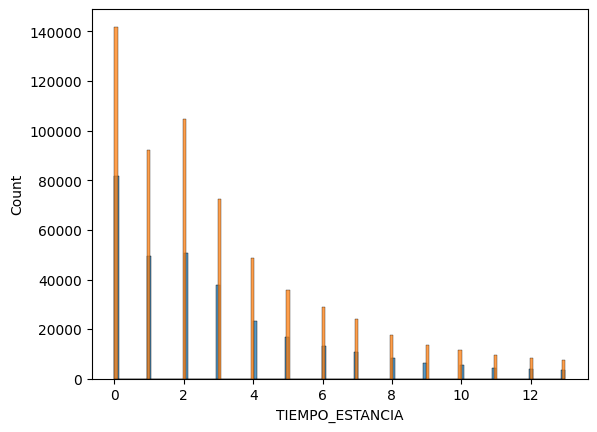

In [13]:
sns.histplot(metropolitana["TIEMPO_ESTANCIA"])
sns.histplot(provincias["TIEMPO_ESTANCIA"])
plt.show()

Prueba t para dos muestras independientes - Estancia por Tipo de Región
Hipótesis nula (H₀): No hay diferencia entre la estancia media de un recinto de la región Metropolitana y Provincia
Hipótesis alternativa (H₁): Hay diferencia entre la estancia media de un recinto de Antofagasta y Concepción
Media Estancia Antofagasta: 3.1077
Media Estancia Concepción: 2.9007
Diferencia de medias: 0.2070
Prueba de Levene para igualdad de varianzas: p=0.0000 (varianzas diferentes)
Estadística t: 30.3567
Valor p: 0.0000
Decisión: Rechazamos la hipótesis nula (p < 0.05)
Conclusión: Existe una diferencia significativa en la estancia media entre Antofagasta y Concepción

Tamaño del efecto (d de Cohen): 0.066
Efecto pequeño


C:\Users\Darienn\AppData\Local\Temp\ipykernel_16472\4068167989.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['metropolitana', 'provincia'], patch_artist=True,


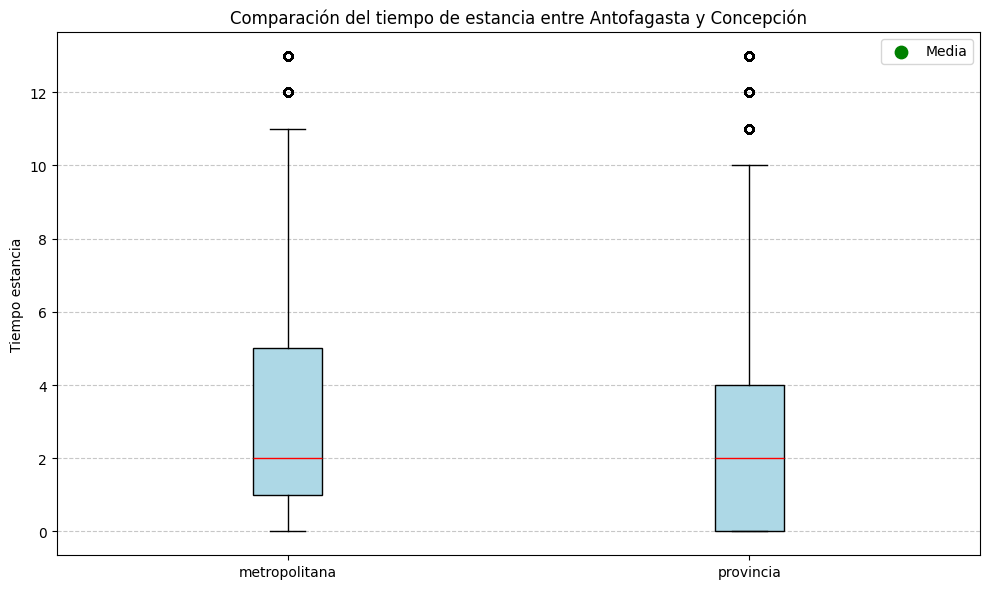

C:\Users\Darienn\AppData\Local\Temp\ipykernel_16472\4068167989.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='TipoRegion', y='TIEMPO_ESTANCIA', data=data, inner='box', palette='pastel')


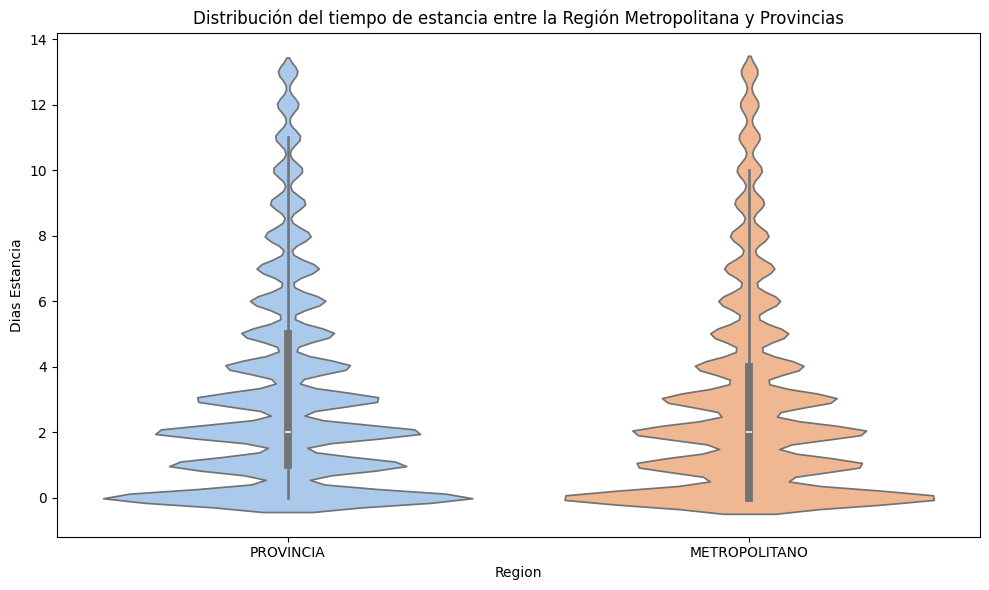

In [14]:
from scipy import stats
grupob = metropolitana["TIEMPO_ESTANCIA"]
grupoa = provincias["TIEMPO_ESTANCIA"]


# Realizar la prueba t para muestras independientes
# Primero verificamos si podemos asumir varianzas iguales con la prueba de Levene
levene_stat, levene_pval = stats.levene(grupoa, grupob)
equal_var = levene_pval >= 0.05  # True si podemos asumir varianzas iguales

# Prueba t para dos muestras independientes
t_stat, p_valor = stats.ttest_ind(grupoa, grupob, equal_var=equal_var)

# Mostrar resultados
print(f"Prueba t para dos muestras independientes - Estancia por Tipo de Región")
print(f"Hipótesis nula (H₀): No hay diferencia entre la estancia media de un recinto de la región Metropolitana y Provincia")
print(f"Hipótesis alternativa (H₁): Hay diferencia entre la estancia media de un recinto de Antofagasta y Concepción")
print(f"Media Estancia Antofagasta: {grupoa.mean():.4f}")
print(f"Media Estancia Concepción: {grupob.mean():.4f}")
print(f"Diferencia de medias: {grupoa.mean() - grupob.mean():.4f}")
print(f"Prueba de Levene para igualdad de varianzas: p={levene_pval:.4f} ({'varianzas iguales' if equal_var else 'varianzas diferentes'})")
print(f"Estadística t: {t_stat:.4f}")
print(f"Valor p: {p_valor:.4f}")

# Decisión estadística
alpha = 0.05
if p_valor < alpha:
    print(f"Decisión: Rechazamos la hipótesis nula (p < {alpha})")
    print(f"Conclusión: Existe una diferencia significativa en la estancia media entre Antofagasta y Concepción")
else:
    print(f"Decisión: No rechazamos la hipótesis nula (p ≥ {alpha})")
    print(f"Conclusión: No hay evidencia suficiente para afirmar que existe diferencia en la estancia media entre Antofagasta y Concepción")

efecto = (grupoa.mean() - grupob.mean()) / np.sqrt((grupoa.std()**2 + grupob.std()**2) / 2)
print(f"\nTamaño del efecto (d de Cohen): {efecto:.3f}")
if abs(efecto) < 0.2:
    print("Efecto pequeño")
elif abs(efecto) < 0.5:
    print("Efecto mediano")
else:
    print("Efecto grande")

# Visualización
plt.figure(figsize=(10, 6))
box_data = [grupoa, grupob]
plt.boxplot(box_data, labels=['metropolitana', 'provincia'], patch_artist=True,
           boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Comparación del tiempo de estancia entre Antofagasta y Concepción')
plt.ylabel('Tiempo estancia')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir las medias como puntos
plt.scatter([1, 2], [grupoa.mean(), grupob.mean()], 
           color='green', marker='o', s=80, label='Media')
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico alternativo con violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='TipoRegion', y='TIEMPO_ESTANCIA', data=data, inner='box', palette='pastel')
plt.title('Distribución del tiempo de estancia entre la Región Metropolitana y Provincias')
plt.xlabel('Region')
plt.ylabel('Dias Estancia')
plt.tight_layout()
plt.show()

In [15]:
data

,TipoRegion,Region,TIPO_INGRESO,TIEMPO_ESTANCIA,EDAD,SEXO,PREVISION
0,PROVINCIA,RIOS,URGENCIA,2,43,HOMBRE,FONASA INSTITUCIONAL - (MAI) A
1,METROPOLITANO,METROPOLITANO,URGENCIA,6,22,HOMBRE,PARTICULAR
2,METROPOLITANO,METROPOLITANO,URGENCIA,1,3,HOMBRE,FONASA INSTITUCIONAL - (MAI) A
3,PROVINCIA,VALPARAISO,PROGRAMADA,1,45,MUJER,FONASA INSTITUCIONAL - (MAI) C
4,PROVINCIA,VALPARAISO,URGENCIA,2,0,MUJER,FONASA INSTITUCIONAL - (MAI) B
...,...,...,...,...,...,...,...
1039582,PROVINCIA,COQUIMBO,OBSTETRICA,3,27,MUJER,FONASA INSTITUCIONAL - (MAI) D
1039583,PROVINCIA,BIOBIO,PROGRAMADA,0,32,MUJER,FONASA INSTITUCIONAL - (MAI) D
1039584,PROVINCIA,LIBERTADOR B. O HIGGINS,URGENCIA,2,9,HOMBRE,FONASA INSTITUCIONAL - (MAI) A
1039585,PROVINCIA,LAGOS,PROGRAMADA,0,9,HOMBRE,FONASA INSTITUCIONAL - (MAI) A


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def propensity_score_calculo(df, columna, valor_columna_a_comparar_1, valor_columna_a_comparar_2, lista_var_confusoras):

    valores_comparacion = [valor_columna_a_comparar_1, valor_columna_a_comparar_2]
    datos = df[df[columna].isin(valores_comparacion)].copy()
    datos["tratamiento"] = (datos[columna] == valor_columna_a_comparar_1).astype(int)
    X = datos[lista_var_confusoras].copy()
    lista_str = [x for x in lista_var_confusoras if datos[x].dtype == "object"]

    if lista_str:
        X = pd.get_dummies(X, columns=lista_str, drop_first=True)

    y = datos["tratamiento"]
    mask = X.notnull().all(axis=1) & y.notnull()
    X = X[mask]
    y = y[mask]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    modelo_ps = LogisticRegression(random_state=42)
    modelo_ps.fit(X_scaled, y)
    datos.loc[X.index, 'propensity_score'] = modelo_ps.predict_proba(X_scaled)[:, 1]
    datos = datos[mask]

    return datos

In [17]:
def match_propensity_scores(df, treatment_col='tratamiento', score_col='propensity_score', caliper=0.05):
    """
    Realiza matching por propensity score con un caliper dado.

    Parámetros:
    -----------
    df : DataFrame
        DataFrame con los datos
    treatment_col : str
        Nombre de la columna que indica el tratamiento (1) o control (0)
    score_col : str
        Nombre de la columna con propensity scores
    caliper : float
        Distancia máxima permitida para el matching

    Retorna:
    --------
    DataFrame con los pares matcheados
    """
    # Separar tratamiento y control
    treated = df[df[treatment_col] == 1].copy()
    control = df[df[treatment_col] == 0].copy()

    # Almacenar índices de matches (usar índices originales)
    treated_indices = []
    control_indices = []

    # Para cada caso tratado, encontrar el control más cercano
    available_controls = control.copy()
    for treated_idx, treated_row in treated.iterrows():
        ps_treated = treated_row[score_col]
        available_controls['distance'] = abs(available_controls[score_col] - ps_treated)

        # Si hay controles disponibles
        if not available_controls.empty:
            best_match_idx = available_controls['distance'].idxmin()
            best_match_distance = available_controls.loc[best_match_idx, 'distance']

            # Verificar caliper
            if best_match_distance < caliper:
                treated_indices.append(treated_idx)
                control_indices.append(best_match_idx)

                # Eliminar el control usado para no reutilizarlo
                available_controls = available_controls.drop(best_match_idx)

    # Crear DataFrame con los pares matcheados usando los índices originales
    matched_treated = treated.loc[treated_indices].reset_index(drop=True)
    matched_control = control.loc[control_indices].reset_index(drop=True)

    return matched_treated, matched_control

In [ ]:
from scipy.stats import ttest_rel

def t_test_pareado(treated, control, variable):
    """
    Realiza una prueba t pareada entre dos grupos (tratamiento y control).

    Parámetros:
    - treated: DataFrame del grupo de tratamiento emparejado.
    - control: DataFrame del grupo de control emparejado.
    - variable: nombre de la columna (string) sobre la que se evalúa la diferencia.

    Retorna:
    - Media grupo tratado
    - Media grupo control
    - Diferencia de medias
    - Estadístico t
    - Valor p
    - Tamaño del efecto (d de Cohen)
    """
    if len(treated) != len(control):
        raise ValueError("Los dataframes deben tener el mismo número de observaciones emparejadas.")
    
    dif = treated[variable] - control[variable]
    t_stat, p_value = ttest_rel(treated[variable], control[variable])
    mean_treated = treated[variable].mean()
    mean_control = control[variable].mean()
    mean_diff = dif.mean()
    std_diff = dif.std()
    d_cohen = mean_diff / std_diff

    print(f"Media {variable} - Tratamiento: {mean_treated:.4f}")
    print(f"Media {variable} - Control:     {mean_control:.4f}")
    print(f"Diferencia de medias:            {mean_diff:.4f}")
    print(f"t = {t_stat:.4f}, p = {p_value:.4f}")
    print(f"Tamaño del efecto (d de Cohen):  {d_cohen:.4f}")
    
    if abs(d_cohen) < 0.2:
        print("Interpretación del tamaño del efecto: Efecto pequeño")
    elif abs(d_cohen) < 0.5:
        print("Interpretación del tamaño del efecto: Efecto mediano")
    else:
        print("Interpretación del tamaño del efecto: Efecto grande")
    
    if p_value < 0.05:
        print("Resultado: La diferencia es estadísticamente significativa.")
    else:
        print("Resultado: No se encontró una diferencia estadísticamente significativa.")
    
    # Visualización de la diferencia
    plt.figure(figsize=(10, 6))
    sns.histplot(dif, kde=True, bins=30, color="skyblue", alpha=0.7)
    plt.axvline(0, color="red", linestyle="--", label="Sin diferencia")
    plt.axvline(mean_diff, color="blue", linestyle="-", label=f"Diferencia media: {mean_diff:.2f}")
    plt.title(f"Distribución de las diferencias en {variable}")
    plt.xlabel(f"Diferencia en {variable}")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return t_stat, p_value, d_cohen

In [19]:
import pandas as pd

# A continuación se muestra un ejemplo de cómo puedes crear una muestra de cada región (excepto la Metropolitana) de forma proporcional al tamaño de cada región, de modo que la suma de dichas muestras sea aproximadamente igual al número de registros de la Región Metropolitana.

# --------------------------------------------------------------------------------

# Supongamos que tu DataFrame se llama 'df' y tiene la columna 'Region'
# que incluye el valor "METROPOLITANO".

# 1) Separamos los datos de la Región Metropolitana de los del resto
df_metro = data[data["Region"] == "METROPOLITANO"].copy()
df_no_metro = data[data["Region"] != "METROPOLITANO"].copy()

# 2) Calculamos cuántos registros hay en la Región Metropolitana
count_metro = len(df_metro)

# 3) Para cada región distinta de la Metropolitana,
#    obtenemos un número de muestras proporcional a su peso relativo dentro de df_no_metro
df_sample_list = []
total_no_metro = len(df_no_metro)

for region, subset in df_no_metro.groupby("Region"):
    # Proporción del total "no metropolitano" que corresponde a 'region'
    proportion = len(subset) / total_no_metro
    
    # Cantidad aproximada de muestras que extraeremos de esa región
    n_samples = int(round(proportion * count_metro))
    
    # Tomamos la muestra
    sample_region = subset.sample(n_samples, random_state=42)
    
    # Agregamos la muestra a la lista
    df_sample_list.append(sample_region)

# 4) Unimos en un único DataFrame todas las muestras de regiones no metropolitanas
df_no_metro_sampled = pd.concat(df_sample_list, ignore_index=True)

# 5) Verificamos tamaños
print("Tamaño total Región Metropolitana:", len(df_metro))
print("Tamaño total de la muestra (regiones no metropolitanas):", len(df_no_metro_sampled))

# df_no_metro_sampled contendrá la muestra resultante
# --------------------------------------------------------------------------------

# En este script:

# • df_metro contiene todos los datos de la Región Metropolitana.  
# • df_no_metro contiene todos los datos de las restantes regiones.  
# • count_metro es la cantidad total de registros metropolitanos.  
# • Para cada región distinta de “METROPOLITANO”, se calcula cuántos registros se deben extraer en proporción a su peso en el total de df_no_metro.  
# • Se concatenan todas las muestras parciales en df_no_metro_sampled, cuya suma final tiende a ser muy cercana al tamaño de la Región Metropolitana.  

# Si quisieras controlar con más precisión el redondeo o pequeños desajustes al final, podrías implementar alguna lógica adicional para compensar los casos donde la suma no coincida exactamente. Sin embargo, este método generalmente produce buenos resultados para la mayoría de los escenarios.

Tamaño total Región Metropolitana: 315359
Tamaño total de la muestra (regiones no metropolitanas): 315356


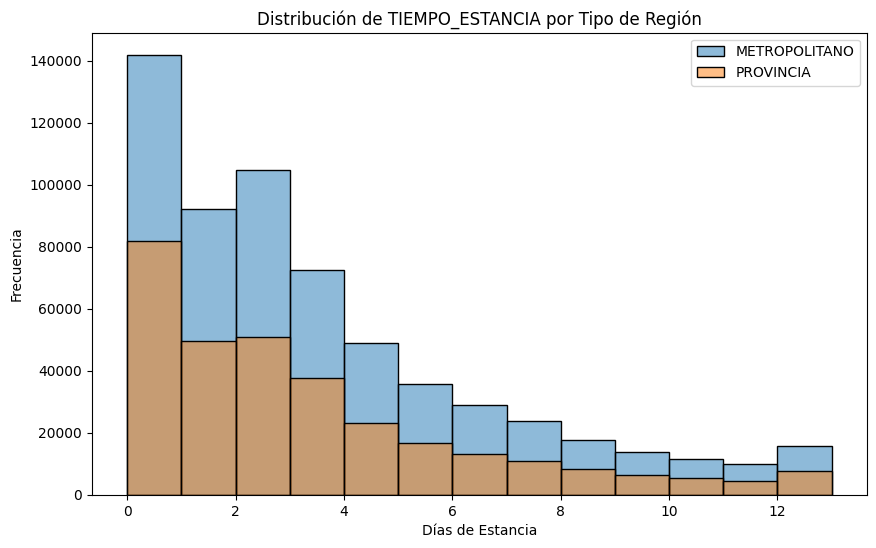

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df_no_metro["TIEMPO_ESTANCIA"], binwidth=1, kde=False, alpha=0.5)
sns.histplot(df_metro["TIEMPO_ESTANCIA"], binwidth=1, kde=False, alpha=0.5)
plt.title("Distribución de TIEMPO_ESTANCIA por Tipo de Región")

plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='x')  # También ayuda a forzar notación normal
plt.xlabel("Días de Estancia")
plt.ylabel("Frecuencia")
plt.legend(["METROPOLITANO","PROVINCIA"])
plt.show()

Prueba t para dos muestras independientes - Estancia por Tipo de Región
Hipótesis nula (H₀): No hay diferencia entre la estancia media de un recinto de la región Metropolitana y Provincia
Hipótesis alternativa (H₁): Hay diferencia entre la estancia media de un recinto de Antofagasta y Concepción
Media Estancia Metropolitana: 3.1077
Media Estancia Regiones: 2.9007
Diferencia de medias: 0.2070
Prueba de Levene para igualdad de varianzas: p=0.0000 (varianzas diferentes)
Estadística t: 30.3567
Valor p: 0.0000
Decisión: Rechazamos la hipótesis nula (p < 0.05)
Conclusión: Existe una diferencia significativa en la estancia media entre Antofagasta y Concepción

Tamaño del efecto (d de Cohen): 0.066
Efecto pequeño


C:\Users\Darienn\AppData\Local\Temp\ipykernel_16472\1018983445.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['metropolitana', 'provincia'], patch_artist=True,


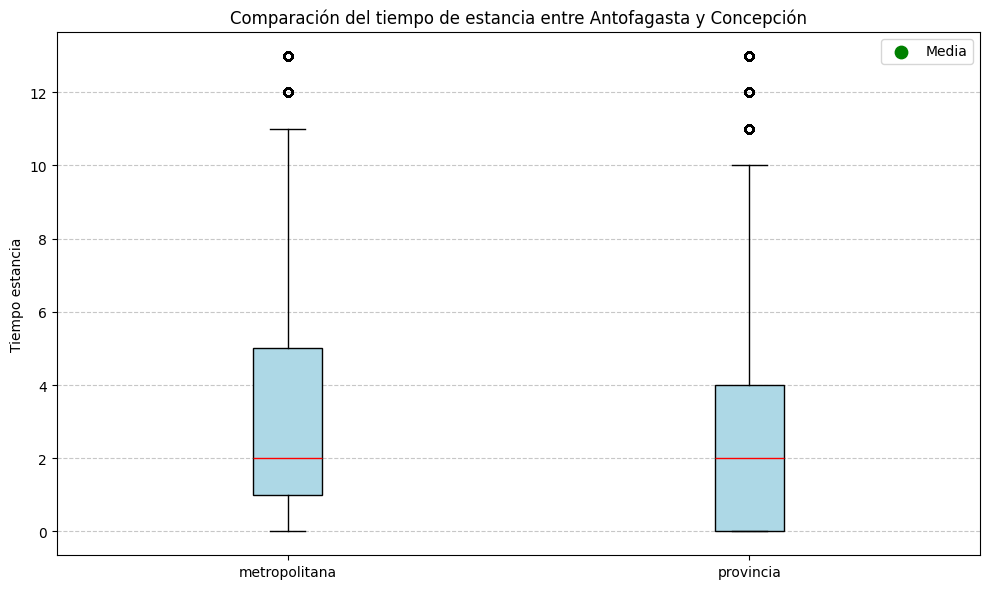

C:\Users\Darienn\AppData\Local\Temp\ipykernel_16472\1018983445.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='TipoRegion', y='TIEMPO_ESTANCIA', data=data, inner='box', palette='pastel')


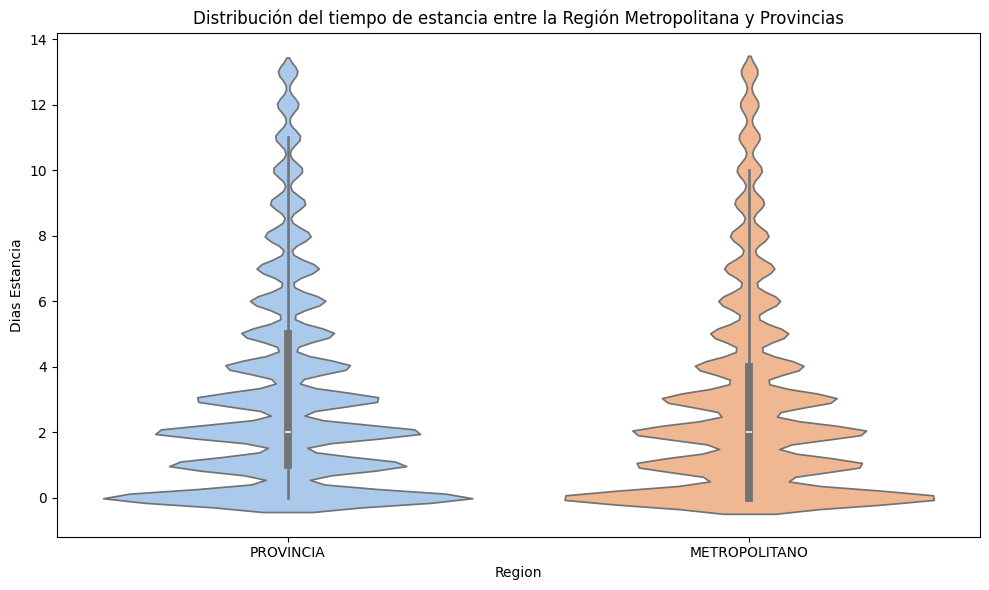

In [21]:
from scipy import stats
grupob = df_metro["TIEMPO_ESTANCIA"]
grupoa = df_no_metro["TIEMPO_ESTANCIA"]


# Realizar la prueba t para muestras independientes
# Primero verificamos si podemos asumir varianzas iguales con la prueba de Levene
levene_stat, levene_pval = stats.levene(grupoa, grupob)
equal_var = levene_pval >= 0.05  # True si podemos asumir varianzas iguales

# Prueba t para dos muestras independientes
t_stat, p_valor = stats.ttest_ind(grupoa, grupob, equal_var=equal_var)

# Mostrar resultados
print(f"Prueba t para dos muestras independientes - Estancia por Tipo de Región")
print(f"Hipótesis nula (H₀): No hay diferencia entre la estancia media de un recinto de la región Metropolitana y Provincia")
print(f"Hipótesis alternativa (H₁): Hay diferencia entre la estancia media de un recinto de Antofagasta y Concepción")
print(f"Media Estancia Metropolitana: {grupoa.mean():.4f}")
print(f"Media Estancia Regiones: {grupob.mean():.4f}")
print(f"Diferencia de medias: {grupoa.mean() - grupob.mean():.4f}")
print(f"Prueba de Levene para igualdad de varianzas: p={levene_pval:.4f} ({'varianzas iguales' if equal_var else 'varianzas diferentes'})")
print(f"Estadística t: {t_stat:.4f}")
print(f"Valor p: {p_valor:.4f}")

# Decisión estadística
alpha = 0.05
if p_valor < alpha:
    print(f"Decisión: Rechazamos la hipótesis nula (p < {alpha})")
    print(f"Conclusión: Existe una diferencia significativa en la estancia media entre Antofagasta y Concepción")
else:
    print(f"Decisión: No rechazamos la hipótesis nula (p ≥ {alpha})")
    print(f"Conclusión: No hay evidencia suficiente para afirmar que existe diferencia en la estancia media entre Antofagasta y Concepción")

efecto = (grupoa.mean() - grupob.mean()) / np.sqrt((grupoa.std()**2 + grupob.std()**2) / 2)
print(f"\nTamaño del efecto (d de Cohen): {efecto:.3f}")
if abs(efecto) < 0.2:
    print("Efecto pequeño")
elif abs(efecto) < 0.5:
    print("Efecto mediano")
else:
    print("Efecto grande")

# Visualización
plt.figure(figsize=(10, 6))
box_data = [grupoa, grupob]
plt.boxplot(box_data, labels=['metropolitana', 'provincia'], patch_artist=True,
           boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
plt.title('Comparación del tiempo de estancia entre Antofagasta y Concepción')
plt.ylabel('Tiempo estancia')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir las medias como puntos
plt.scatter([1, 2], [grupoa.mean(), grupob.mean()], 
           color='green', marker='o', s=80, label='Media')
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico alternativo con violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='TipoRegion', y='TIEMPO_ESTANCIA', data=data, inner='box', palette='pastel')
plt.title('Distribución del tiempo de estancia entre la Región Metropolitana y Provincias')
plt.xlabel('Region')
plt.ylabel('Dias Estancia')
plt.tight_layout()
plt.show()

In [33]:
df_all = pd.concat([df_metro.sample(100000, replace=False), df_no_metro_sampled.sample(100000, replace=False)], ignore_index=True)

pdf = propensity_score_calculo(df_all, "TipoRegion", "METROPOLITANO", "PROVINCIA", ["EDAD","SEXO","PREVISION"])
treated_matched, control_matched = match_propensity_scores(pdf)
print(f"Número de pares matcheados: {len(treated_matched)}")
t_test_pareado(treated_matched,control_matched,"TIEMPO_ESTANCIA")

: 

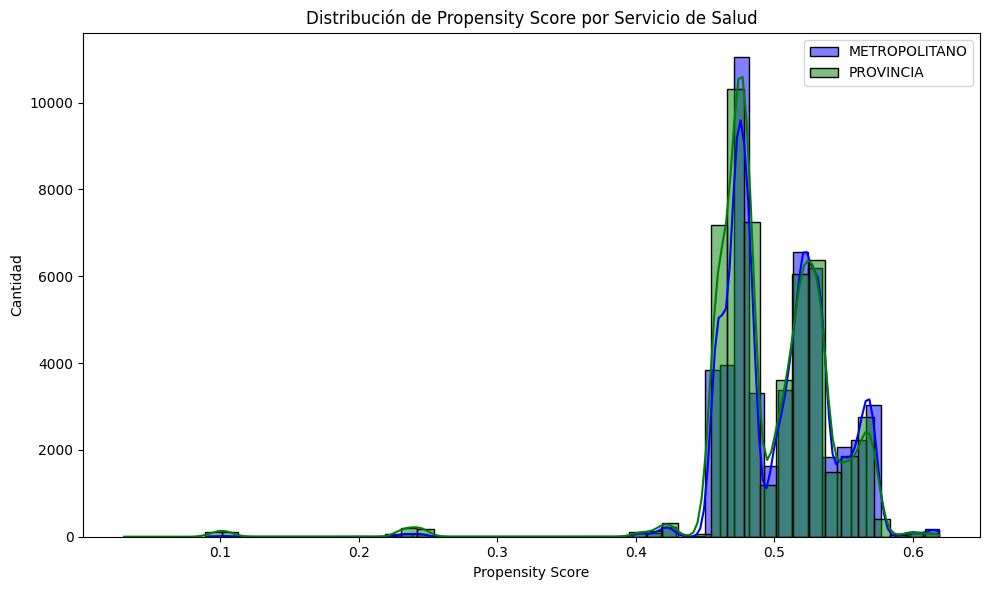

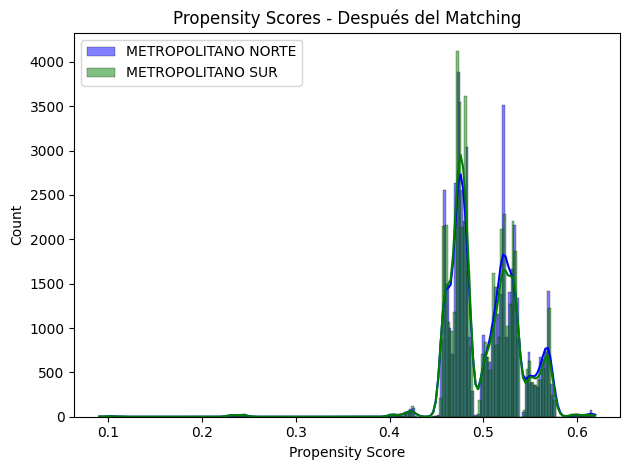

In [31]:
servicios_a_comparar = ["METROPOLITANO","PROVINCIA"]

plt.figure(figsize=(10, 6))
for servicio, color in zip(servicios_a_comparar, ['blue', 'green']):
    subset = pdf[pdf['TipoRegion'] == servicio]
    sns.histplot(subset['propensity_score'], kde=True, bins=50, color=color, label=servicio, alpha=0.5)
plt.xlabel('Propensity Score')
plt.ylabel('Cantidad')
plt.title('Distribución de Propensity Score por Servicio de Salud')
plt.legend()
plt.tight_layout()
plt.show()

sns.histplot(treated_matched['propensity_score'], color='blue', alpha=0.5,
             label='METROPOLITANO NORTE', kde=True)
sns.histplot(control_matched['propensity_score'], color='green', alpha=0.5,
             label='METROPOLITANO SUR', kde=True)
plt.title('Propensity Scores - Después del Matching')
plt.xlabel('Propensity Score')
plt.legend()

plt.tight_layout()
plt.show()


Media TIEMPO_ESTANCIA - Tratamiento: 2.8952
Media TIEMPO_ESTANCIA - Control:     3.1400
Diferencia de medias:            -0.2448
t = -5.5593, p = 0.0000
Resultado: La diferencia es estadísticamente significativa.


(np.float64(-5.559269269012921), np.float64(2.7806730037070657e-08))